In [1]:
from abc import ABC, abstractmethod
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
import random as rand
import time

import libraries.autodiff_symbolic as symbolic
import libraries.autodiff_forwards as forwards
import libraries.autodiff_simple_backwards as backwards
import torch

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
def get_all_grads_symbolic(n: int) -> List[float]:
    eqn = symbolic.Variable("x")

    weight_names = []
    bias_names = []
    for i in range(n):
        w_name = "w" + str(i+1)
        b_name = "b" + str(i+1)

        weight_names.append(w_name)
        bias_names.append(b_name)

        w = symbolic.Variable(w_name)
        b = symbolic.Variable(b_name)

        eqn = symbolic.Tanh(symbolic.Add(symbolic.Mult(w, eqn), b))
    
    vars = weight_names + bias_names

    ctx = {}
    ctx["x"] = rand.random()
    for var in vars:    
        ctx[var] = rand.random()

    grads = []
    for var in vars:
        grads.append(eqn.diff(var).run(ctx))
    
    return grads

def get_all_grads_forwards(n: int) -> List[float]:
    x = forwards.DualFloat(rand.random(), 0)
    weights = [forwards.DualFloat(rand.random(), 0) for _ in range(n)]
    biases = [forwards.DualFloat(rand.random(), 0) for _ in range(n)]

    grads = []
    for solving_weight in [True, False]:
        for i in range(n):
            res = x
            for j in range(n):
                weight = weights[j]
                bias = biases[j]

                if i == j:
                    if solving_weight:
                        weight = forwards.DualFloat(weights[j].real_part, 1)
                    else:
                        bias = forwards.DualFloat(biases[j].real_part, 1)

                res = (weight * res + bias).tanh()
            
            grads.append(res.dual_part)

    return grads

def get_all_grads_backwards(n: int) -> List[float]:
    acc = backwards.Variable(0) # x

    for i in range(n):
        w = backwards.Variable(1+i)
        b = backwards.Variable(1+n+i)

        acc = backwards.Tanh(backwards.Add(backwards.Mult(w, acc), b))
    
    ctx = [rand.random() for _ in range(2*n+1)]

    eqn = acc.to_equation()
    eqn.forwards(ctx)
    return eqn.backwards_from_last_forwards()[1:]

def get_all_grads_torch(n: int) -> List[float]:
    acc = torch.tensor(rand.random(), requires_grad=True)

    weights = []
    biases = []
    for i in range(n):
        w = torch.tensor(rand.random(), requires_grad=True)
        b = torch.tensor(rand.random(), requires_grad=True)

        weights.append(w)
        biases.append(b)

        acc = torch.tanh((w * acc) + b)
    
    acc.backward()

    return [weight.grad for weight in weights] + [bias.grad for bias in biases]

def time_func(func, n: int) -> float:
    start = time.time()
    func(n)
    end = time.time()
    return end - start


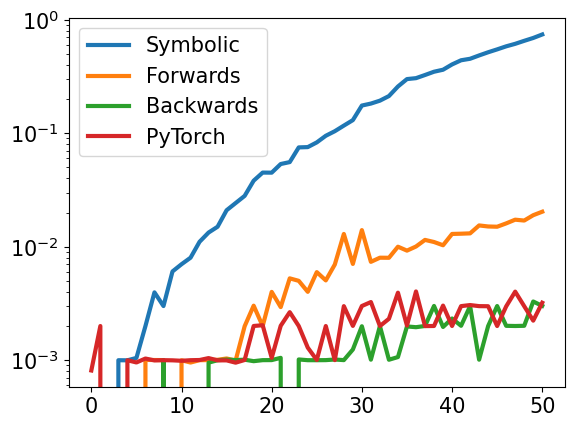

In [5]:
MAX_N = 50

times_sym = []
times_forwards = []
times_backwards = []
times_torch = []
for i in range(0, MAX_N+1):
    times_sym.append(time_func(get_all_grads_symbolic, i))
    times_forwards.append(time_func(get_all_grads_forwards, i))
    times_backwards.append(time_func(get_all_grads_backwards, i))
    times_torch.append(time_func(get_all_grads_torch, i))

plt.plot(range(0, MAX_N+1), times_sym, linewidth=3)
plt.plot(range(0, MAX_N+1), times_forwards, linewidth=3)
plt.plot(range(0, MAX_N+1), times_backwards, linewidth=3)
plt.plot(range(0, MAX_N+1), times_torch, linewidth=3)
plt.legend(['Symbolic', 'Forwards', 'Backwards', 'PyTorch'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()

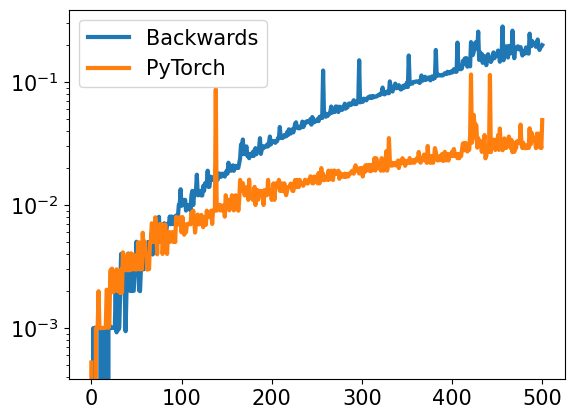

In [7]:
MAX_N = 500

times_backwards = []
times_torch = []
for i in range(0, MAX_N+1):
    times_backwards.append(time_func(get_all_grads_backwards, i))
    times_torch.append(time_func(get_all_grads_torch, i))

plt.plot(range(0, MAX_N+1), times_backwards, linewidth=3)
plt.plot(range(0, MAX_N+1), times_torch, linewidth=3)
plt.legend(['Backwards', 'PyTorch'], fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.show()